# 3. 時系列データの時間依存と自己回帰モデル

## 3-1. 時間依存の表現

データをhずつずらして相関係数を取ったものを自己相関係数という．ラグhを変数とする時，それは自己相関関数と呼ばれる．横軸にh，縦軸に自己相関係数を取ったものをコレログラムと呼ぶ．

4社のコレログラムを表示し，95%信頼区間(薄い青色で表示されている部分)と比較してみると，ポーラHDのh=1での自己相関係数のみ有意であることわかる．

例えばh=6の時，自己相関係数はラグ6での相関を表しているが，ここには間接的にh=1,2,...の関係も含まれている．これらの影響を取り除き，ラグ間での直接的な相関係数を調べたのが偏自己相関係数である．

自己相関を有しているかどうかの検定がLjung-Box検定である．p値が有意水準よりも小さい時，相関関係があると判断される．

In [1]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import pandas_datareader as pdr

plt.rcParams["font.size"] = 24
start = datetime.date(2012, 9, 30)
end = datetime.date(2013, 3, 31)
stocks = [
    {'code':'5202.JP', 'company':'Nippon Sheet Glass'},
    {'code':'7272.JP', 'company':'Yamaha'},
    {'code':'4927.JP', 'company':'Pola HD'},
    {'code':'4502.JP', 'company':'Takeda Pharmaceutical Company'},
]

for i, s in enumerate(stocks):
    df = pdr.data.DataReader(stocks[i]['code'], 'stooq', start, end).iloc[::-1]
    stocks[i]['data'] = df

for i, s in enumerate(stocks):
    df = pdr.data.DataReader(stocks[i]['code'], 'stooq', start, end).iloc[::-1]
    stocks[i]['data']['log'] = np.log(stocks[i]['data']['Close'])
    # 対数差収益率
    stocks[i]['data']['log_return'] = stocks[i]['data']['log'].diff().dropna()
    stocks[i]['data'].dropna(inplace=True)

AttributeError: module 'statsmodels' has no attribute 'graphics'

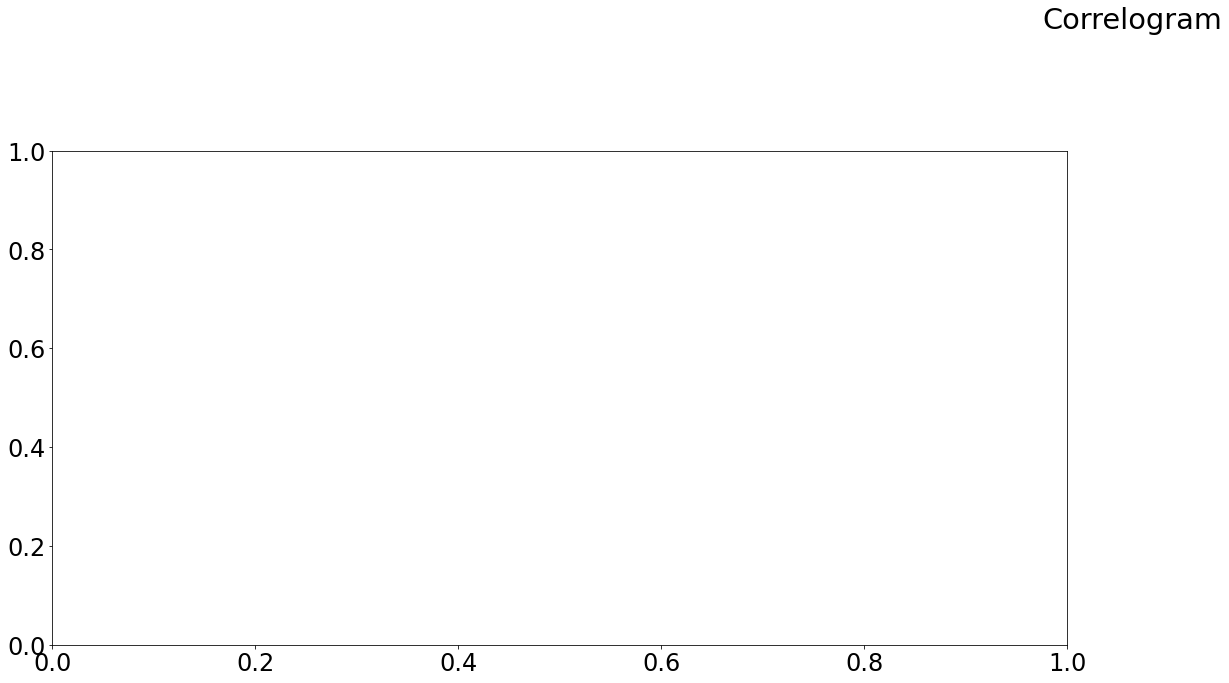

In [2]:
import statsmodels

fig = plt.figure(figsize=(40,20))
fig.suptitle('Correlogram')
for i, s in enumerate(stocks):
    ax = fig.add_subplot(2,2,i+1)
    statsmodels.graphics.tsaplots.plot_acf(s['data']['log_return'], lags=20, ax=ax)
    ax.set_title(s['company'])

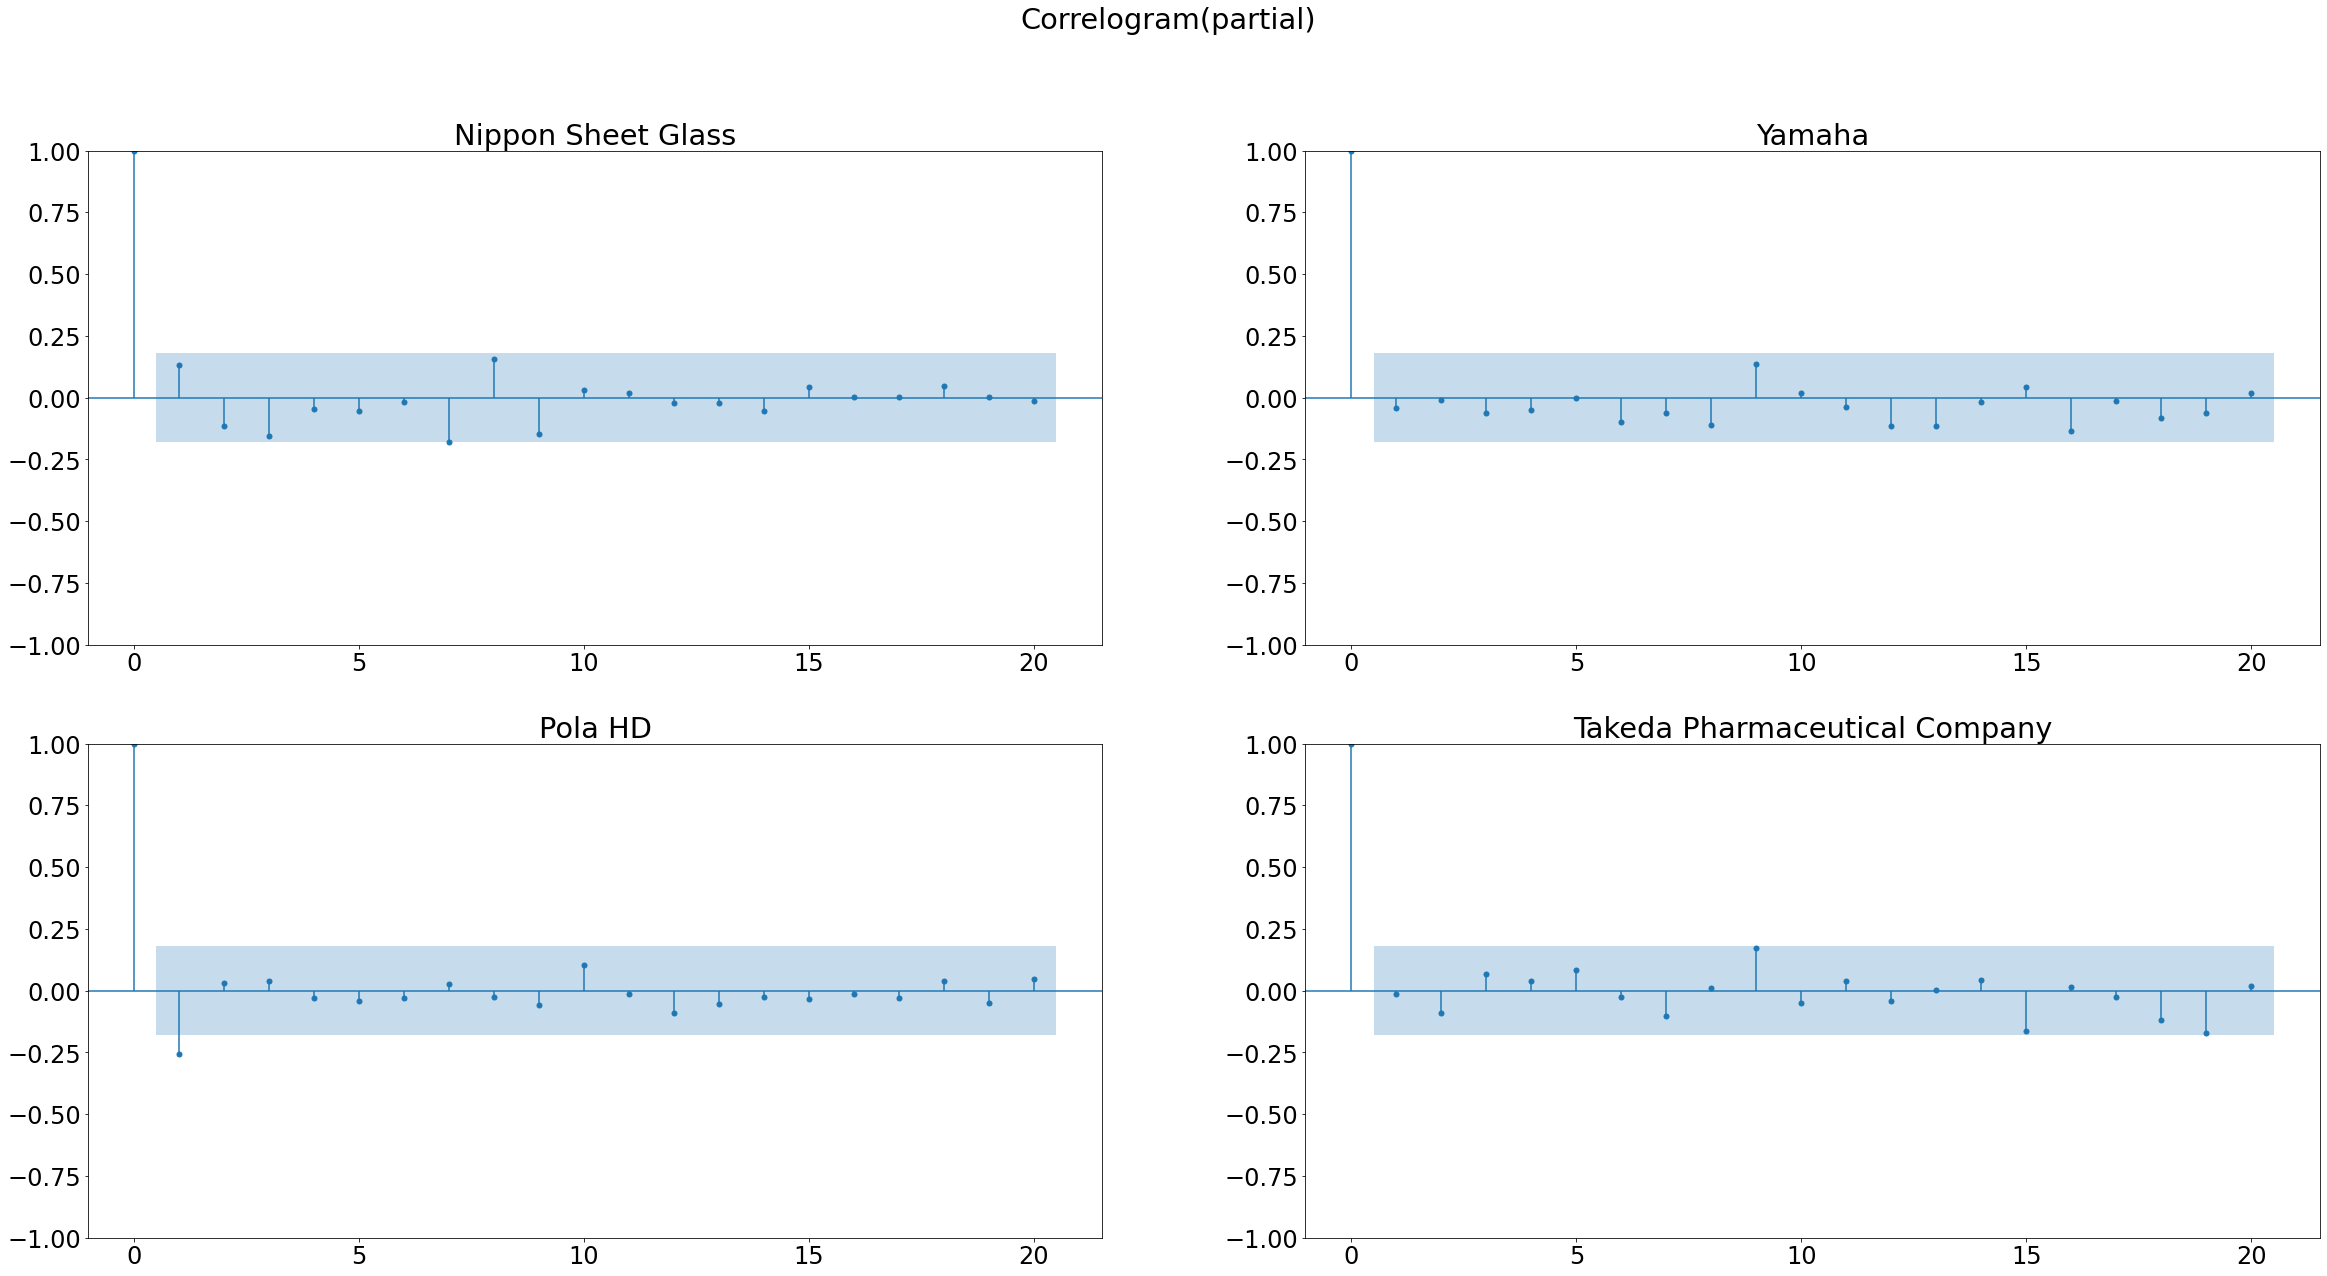

In [ ]:
import statsmodels

fig = plt.figure(figsize=(40,20))
fig.suptitle('Correlogram(partial)')
for i, s in enumerate(stocks):
    ax = fig.add_subplot(2,2,i+1)
    statsmodels.graphics.tsaplots.plot_pacf(s['data']['log_return'], lags=20, ax=ax, method='ywm')
    ax.set_title(s['company'])

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
for i, s in enumerate(stocks):
    print("{}\n{}".format(s['company'], acorr_ljungbox(s['data']['log_return'])))

Nippon Sheet Glass
      lb_stat  lb_pvalue
1    2.126540   0.144767
2    3.198693   0.202028
3    7.116809   0.068266
4    7.912196   0.094848
5    8.090934   0.151295
6    8.108509   0.230261
7   10.663311   0.153994
8   12.712740   0.122123
9   13.105383   0.157895
10  13.175560   0.214021
Yamaha
     lb_stat  lb_pvalue
1   0.203191   0.652157
2   0.207362   0.901513
3   0.683237   0.877140
4   0.941320   0.918559
5   0.942392   0.967077
6   2.030754   0.916848
7   2.285388   0.942373
8   3.521261   0.897533
9   6.727725   0.665443
10  6.799715   0.744208
Pola HD
      lb_stat  lb_pvalue
1    8.045530   0.004562
2    9.126808   0.010427
3    9.130342   0.027607
4    9.269335   0.054709
5    9.313312   0.097201
6    9.354833   0.154584
7    9.473730   0.220409
8    9.704846   0.286356
9    9.833717   0.364114
10  11.594562   0.313107
Takeda Pharmaceutical Company
     lb_stat  lb_pvalue
1   0.024618   0.875324
2   1.033423   0.596479
3   1.658607   0.646175
4   1.927951   0.749009
5 

## 3-2 時系列データの性質 -定常性について-

時刻tにおける確率変数を$R_t$とおく．
弱定常性では，$E(R_t)=a, Var(R_t)=\gamma_0, Cov(R_t)=\gamma_h$という仮定が置かれる．それぞれが時刻$t$に依存していないことに注意する．

$E(R_t)=a, Var(R_t)=\gamma_0$だけなら，単純に実現値$r_t$がi.i.dあることを述べているに過ぎない．しかし，$Cov(R_t)=\gamma_h$という条件が加わると，ある時刻での$R_t$は，その前の$R_t$に多少の影響を受けていると仮定していることになる．

この定常性を仮定して，さまざまなモデルが作られている．

ホワイトノイズは，$E(R_t)=0, Var(R_t)=\sigma^2, Cov(R_t)=0$となる定常性を持つデータのことである．$Cov(R_t)=0$ということは，ホワイトノイズはどのラグの影響も受けない．すなわち，ランダムな分布を持つ時系列データといえる．

## 3-3. 自己回帰モデルの導入

$R_t = \mu + \sum_1^h \Phi_h R_(t-h) + \epsilon_t$と時系列過程を表す手法を自己回帰モデルと表す．h分のラグを考慮しているこの式を，AR(h)と表現する．

In [ ]:
import statsmodels.api as sm
for i, s in enumerate(stocks):
    print(s['company'])
    for i in range(20):
        model = sm.tsa.AutoReg(np.array(s['data']['log_return']), lags=i+1)
        results = model.fit()
        print("{}:\t{}".format(i+1,results.aic))

Nippon Sheet Glass
1:	-442.3354131375735
2:	-437.1684373529755
3:	-434.67524606971836
4:	-428.49862223416017
5:	-422.28182150741634
6:	-416.01824209085834
7:	-413.1130382850542
8:	-409.8073010442717
9:	-405.6576397384487
10:	-398.88596983369735
11:	-393.6293282577134
12:	-386.84864972819594
13:	-380.1387160602299
14:	-373.96695344976087
15:	-367.2959693951074
16:	-364.21745503772047
17:	-357.3553754797028
18:	-350.98004340710276
19:	-344.11473565747326
20:	-339.099490997863
Yamaha
1:	-511.8293118207207
2:	-504.42582600599496
3:	-500.7813055886736
4:	-494.0895396457498
5:	-487.18750279779505
6:	-480.9958597712164
7:	-474.29646081074924
8:	-468.353259246488
9:	-464.0809088709697
10:	-456.70065844953956
11:	-449.4100591652551
12:	-444.01538807474395
13:	-438.21057143196606
14:	-430.8044222779746
15:	-423.7424782972916
16:	-418.5497609773345
17:	-411.1380816930689
18:	-404.97164085671744
19:	-399.9174226843812
20:	-392.6811896173363
Pola HD
1:	-648.417531803745
2:	-641.6096388366765
3:	-63

## 3-4. 単位根過程について

$\Phi_1=1$となる時系列過程を，単位根過程と呼ぶ．この時，$R_t - R_(t-1) = \epsilon_t$となり，差分が確率的に変動し，ランダムウォークとなっている．